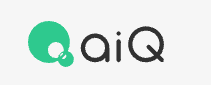

[disclaimer](../../disclaimer.txt/)

# aiQ POS Retailer Data Evaluation

- aiQ POS Retailer is data that consolidates the sales of products sold in retail stores such as supermarkets, drugstores, and convenience stores, organized by TICKER.

In [1]:
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')

from libs.dataset import aiq_pos_retailer as sc_retailer
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [3]:
sdh = DAL()

## Step2: Load Data to `sdh`

Since the focus here is on demonstrating data analysis, the data will be loaded through a simple loader that has been prepared separately.

In [4]:
sdh.extract.clear()

data_id_alt = sc_retailer.register_retailer_data(sdh, data_dir=DEFAULT_DIR)
data_id_mkt = sc_common.register_market(sdh, yf_switch=False, base_data_id=data_id_alt)
data_id_funda = sc_common.register_fundamental(sdh)
display(sdh.extract_definition)

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,external,sample,Unknown,pos_retailer,None,None,None,None
2,RawData,External,Unknown,Unknown,market_returns,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-08-30 00:00:00
3,RawData,External,Unknown,Unknown,funda,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[TICKER, DATETIME]",2007-04-20 00:00:00,2024-05-31 00:00:00


In [5]:
# Randomly select a TICKER to plot as a sample.
sample_target = "3141"

In [6]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_mkt).tail())
display(sdh.get_raw_data(data_id_funda).tail())

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
89431,9994,BBG000C2XBL7,2024-06-30,share,0,0.394184,0,2024-07-05 07:28:10
89432,9994,BBG000C2XBL7,2024-07-31,pos_sales,0,3.110237,0,2024-08-07 09:04:03
89433,9994,BBG000C2XBL7,2024-07-31,share,0,0.401014,0,2024-08-07 09:04:03
89434,9994,BBG000C2XBL7,2024-08-31,pos_sales,0,2.805866,0,2024-09-06 05:47:07
89435,9994,BBG000C2XBL7,2024-08-31,share,0,0.370834,0,2024-09-06 05:47:07


returns  returns_oo  returns_id  returns_on
TICKER DATETIME                                                
9997   2024-08-26 -0.016416   -0.001356   -0.016416    0.000000
       2024-08-27  0.000000   -0.010914   -0.005502    0.005502
       2024-08-28  0.016416   -0.005502    0.016416    0.000000
       2024-08-29 -0.002717    0.015058   -0.001360   -0.001358
       2024-08-30  0.009479    0.002714    0.005405    0.004073

sales_yoy
TICKER DATETIME             
9997   2023-03-31   0.008141
       2023-06-30  -0.030340
       2023-09-30  -0.024041
       2023-12-31  -0.024655
       2024-03-31   0.001886

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [7]:
USE_MY_FUNDA = False 

> If you want to use your own market data with the handler (or set `yf_switch`=True in `register_market`) , please set the following flag to True. <br> Note that the sample market data has already been adjusted for Returns.

In [8]:
USE_MY_MKT = False

## Step3: Correlation Analysis

### Create `AltDataEvaluator`
Given the nature of aiQ POS Retailer data, it is expected that there may be a correlation with financial data (quarterly sales).

Here, we will test this hypothesis to determine its validity.

#### Use `AltDataEvaluator` to evaluate the alternative data.

In [9]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

#### Compare the Quarterly Sales Data Loaded in Step 2 with the `pos_sales` from POS Retailer
- To enable comparison between the quarterly sales data and `pos_sales`, resample the latter.

In [10]:
sdh.transform.clear()
funda_kpi_id = sdh.transform.raw(data_id=data_id_funda).variable_ids[0]
pos_Q_ids = sdh.transform.resample_by(label=funda_kpi_id, func='last', data_id=data_id_alt).variable_ids

## Step 3.1: Plot with Quarterly Sales

Plot the quarterly sales data alongside the alternative data to visually inspect the data shapes.
> It is recommended to compare with your financial data before applying YoY adjustments.

#### Create Variables from the Base `variable` and Visually Identify Which Matches the Financial Data
- By using `sdh.transform`, you can create various variables and quickly evaluate which one has the strongest relationship with the financial data.
- For a list of `transform` processes, please refer to the sample notebook provided with the `data handler`.

In [11]:
if USE_MY_FUNDA:
    
    # Plot the data to visually inspect its shape.
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_kpi_id,
        X= pos_Q_ids[:],
        col_num=2,
        vname_len_limit=40,
        start_date='2016-01-01'
    )

    # First, define the variables.
    shft1_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft2_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft3_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft4_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft5_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft6_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft7_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft8_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft9_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=9).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft10_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=10).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft11_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=11).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft12_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=12).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft13_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=13).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft14_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=14).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft15_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=15).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft16_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=16).resample_by(label=funda_kpi_id, func='last').variable_ids

    # Plot the variables created above to visually inspect them.
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_kpi_id,
        X= [shft1_Q_ids[0], shft3_Q_ids[0], shft6_Q_ids[0], shft9_Q_ids[0]],
        col_num=2,
        vname_len_limit=45,
        start_date='2016-01-01'
    )

     # For the next step, calculate the year-over-year (YoY) changes and create a variable with an additional lagged difference to address cases where trends might cause apparent correlations.
    funda_kpi_log_id = sdh.transform.log_diff(fields=funda_kpi_id, periods=4).diff(periods=1).variable_ids[-1]
    

In [12]:
if not USE_MY_FUNDA:

    # Convert the POS data to YoY as well for comparison with the financial data.
    pos_Q_yoy_ids = sdh.transform.log_diff(periods=4, fields=pos_Q_ids).variable_ids

    # Plot the data to visually inspect its shape.
    sdh.show_scatter_one_target(
        target=sample_target,
        y=funda_kpi_id,
        X=pos_Q_yoy_ids,
        col_num=2,
        vname_len_limit=35
    )

    # Define the variables.
    shft1_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft2_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft3_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft4_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft5_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft6_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft7_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft8_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft9_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=9).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft10_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=10).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft11_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=11).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft12_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=12).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft13_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=13).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft14_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=14).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft15_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=15).resample_by(label=funda_kpi_id, func='last').variable_ids
    shft16_Q_ids = sdh.transform.shift(data_id=data_id_alt, periods=16).resample_by(label=funda_kpi_id, func='last').variable_ids
    
    # To address cases where trends might cause apparent correlations, create a variable with an additional lagged difference.
    funda_kpi_log_id = sdh.transform.diff(fields=funda_kpi_id, periods=1).variable_ids[-1]

ValueError: MultiIndex has no single backing array. Use 'MultiIndex.to_numpy()' to get a NumPy array of tuples.

In [ ]:
# Calculate the year-over-year (YoY) changes and create a variable with an additional lagged difference to account for cases where trends might cause apparent correlations.
shft0_Q_log_ids = sdh.transform.log_diff(fields=pos_Q_ids, periods=4).diff(periods=1).variable_ids
shft1_Q_log_ids = sdh.transform.log_diff(fields=shft1_Q_ids, periods=4).diff(periods=1).variable_ids
shft2_Q_log_ids = sdh.transform.log_diff(fields=shft2_Q_ids, periods=4).diff(periods=1).variable_ids
shft3_Q_log_ids = sdh.transform.log_diff(fields=shft3_Q_ids, periods=4).diff(periods=1).variable_ids
shft4_Q_log_ids = sdh.transform.log_diff(fields=shft4_Q_ids, periods=4).diff(periods=1).variable_ids
shft5_Q_log_ids = sdh.transform.log_diff(fields=shft5_Q_ids, periods=4).diff(periods=1).variable_ids
shft6_Q_log_ids = sdh.transform.log_diff(fields=shft6_Q_ids, periods=4).diff(periods=1).variable_ids
shft7_Q_log_ids = sdh.transform.log_diff(fields=shft7_Q_ids, periods=4).diff(periods=1).variable_ids
shft8_Q_log_ids = sdh.transform.log_diff(fields=shft8_Q_ids, periods=4).diff(periods=1).variable_ids
shft9_Q_log_ids = sdh.transform.log_diff(fields=shft9_Q_ids, periods=4).diff(periods=1).variable_ids
shft10_Q_log_ids = sdh.transform.log_diff(fields=shft10_Q_ids, periods=4).diff(periods=1).variable_ids
shft11_Q_log_ids = sdh.transform.log_diff(fields=shft11_Q_ids, periods=4).diff(periods=1).variable_ids
shft12_Q_log_ids = sdh.transform.log_diff(fields=shft12_Q_ids, periods=4).diff(periods=1).variable_ids
shft13_Q_log_ids = sdh.transform.log_diff(fields=shft13_Q_ids, periods=4).diff(periods=1).variable_ids
shft14_Q_log_ids = sdh.transform.log_diff(fields=shft14_Q_ids, periods=4).diff(periods=1).variable_ids
shft15_Q_log_ids = sdh.transform.log_diff(fields=shft15_Q_ids, periods=4).diff(periods=1).variable_ids
shft16_Q_log_ids = sdh.transform.log_diff(fields=shft16_Q_ids, periods=4).diff(periods=1).variable_ids

#### Correlation Calculation

In [ ]:
ori_cols = sdh.get_raw_data(data_id_alt).columns
ori_cols

In [ ]:
rho_pool = pd.DataFrame()
rho_pool['shift=0'] = ade.compu_rho(shft0_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=1'] = ade.compu_rho(shft1_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=2'] = ade.compu_rho(shft2_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=3'] = ade.compu_rho(shft3_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=4'] = ade.compu_rho(shft4_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=5'] = ade.compu_rho(shft5_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=6'] = ade.compu_rho(shft6_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=7'] = ade.compu_rho(shft7_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=8'] = ade.compu_rho(shft8_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=9'] = ade.compu_rho(shft9_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=10'] = ade.compu_rho(shft10_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=11'] = ade.compu_rho(shft11_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=12'] = ade.compu_rho(shft12_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=13'] = ade.compu_rho(shft13_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=14'] = ade.compu_rho(shft14_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=15'] = ade.compu_rho(shft15_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)
rho_pool['shift=16'] = ade.compu_rho(shft16_Q_log_ids, funda_kpi_log_id, rename_features=ori_cols)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

In [ ]:
display(rho_pool.xs('rho', level=1).sort_values(rho_pool.columns[0], ascending=False))

> Review the top N tickers among those with the highest correlation values.

In [ ]:
rho_time = ade.compu_rho(shft1_Q_log_ids, funda_kpi_log_id, by='ticker', rename_features=ori_cols)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

> Review the variables and plot them in a scatter plot.

In [ ]:
display(sdh.transform.find_variables(shft1_Q_log_ids))

feature = 76 # pos_sales

In [ ]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=funda_kpi_log_id,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45,
    start_date='2016-01-01'
)

### Step 3.2: Correlation with Stock Price Changes
- Having confirmed a strong correlation between financial data and POS Retailer data, the next step is to examine the correlation with stock price changes.

> Resample to monthly data.

In [ ]:
resample_term = 'M'
n_rolling = 2  # 2 months rolling mean

pos_sales_and_share = sdh.transform.resample(data_id=data_id_alt, rule=resample_term, func='last', names=["pos_sales", "share"]).variable_ids
pos_sales_vs_share = sdh.transform.mul(x1field=pos_sales_and_share[0], x2field=pos_sales_and_share[1], name='pos_sales * share').variable_ids[0]
alt_M_ids = sdh.transform.sma(n_rolling, fields=pos_sales_and_share+[pos_sales_vs_share]).variable_ids # pos_sales, share, pos_sales * share

if USE_MY_MKT:
    mkt_M_close_id = sdh.transform.resample('D', 'last', data_id=data_id_mkt, fields='close').fillna(method='ffill').shift(-7).reindex(label=alt_M_ids[0]).variable_ids[-1]
else:
    mkt_M_close_id = sdh.transform.resample('D', 'last', data_id=data_id_mkt, fields='returns').fillna(0).cumsum().shift(-7).reindex(label=alt_M_ids[0]).variable_ids[-1]

In [ ]:
alt_names = ["pos_sales", "share", "pos_sales * share"]

> Visualize the price data and POS data.

In [ ]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_M_close_id,
    X= alt_M_ids[:4],
    col_num=2,
    vname_len_limit=40,
)

> Observe how the plot of sales data changes by shifting the time series of the data.

In [ ]:
shift1_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=1).variable_ids
shift2_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=2).variable_ids
shift3_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=3).variable_ids
shift4_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=4).variable_ids
shift5_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=5).variable_ids
shift6_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=6).variable_ids
shift7_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=7).variable_ids
shift8_M_ids = sdh.transform.shift(fields=alt_M_ids, periods=8).variable_ids

In [ ]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_M_close_id,
    X= [shift1_M_ids[0], shift3_M_ids[0], shift6_M_ids[0], shift8_M_ids[0]],
    col_num=2,
    vname_len_limit=45,
)

> Make `return`

In [ ]:
if USE_MY_MKT:
    close_return = sdh.transform.dropna(fields=mkt_M_close_id).log_diff(1).variable_ids[-1]
else:
    close_return = sdh.transform.dropna(fields=mkt_M_close_id).diff(1).variable_ids[-1]

> Perform correlation calculations by applying a logarithmic transformation to the features.

In [ ]:

n_diff = 12  # 12 months (1 year) difference
log_shift0_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).variable_ids
log_shift1_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=1).variable_ids
log_shift2_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=2).variable_ids
log_shift3_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=3).variable_ids
log_shift4_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=4).variable_ids
log_shift5_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=5).variable_ids
log_shift6_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=6).variable_ids
log_shift7_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=7).variable_ids
log_shift8_M_ids = sdh.transform.log_diff(fields=alt_M_ids, periods=n_diff).shift(periods=8).variable_ids

In [ ]:
rho_pool = pd.DataFrame()
rho_pool['shift=0'] = ade.compu_rho(log_shift0_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=1'] = ade.compu_rho(log_shift1_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=2'] = ade.compu_rho(log_shift2_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=3'] = ade.compu_rho(log_shift3_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=4'] = ade.compu_rho(log_shift4_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=5'] = ade.compu_rho(log_shift5_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=6'] = ade.compu_rho(log_shift6_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=7'] = ade.compu_rho(log_shift7_M_ids, close_return, rename_features=alt_names)
rho_pool['shift=8'] = ade.compu_rho(log_shift8_M_ids, close_return, rename_features=alt_names)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

> Review the top N tickers among those with the highest correlation values.

In [ ]:
rho_time = ade.compu_rho(log_shift1_M_ids, close_return, by='ticker', rename_features=alt_names)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

> Review the variables and plot them in a scatter plot.

In [ ]:
display(sdh.transform.find_variables(log_shift1_M_ids))

feature = log_shift1_M_ids[0] # pos_sales
feature

In [ ]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_return,
    x=feature,
    targets=top6tickers,
    col_num=3,
    vname_len_limit=45
)

## Step 4: Quantile Backtest
- Based on the variables created in Step 3, various factors will be generated and calculations will be performed.
- Here, the 12-week moving average of the `pos_sales` variable is chosen as the factor value.
- In practice, you should vary hyperparameters such as the moving average period and shift intervals to ensure that the backtest results are not significantly affected.

In [ ]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [ ]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature,
    close_return,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)